In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from plotnine import *
import matplotlib
import matplotlib.pyplot as plt
import datetime

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
all_validated = pd.read_csv("../data/processed/all_validated.csv", parse_dates=['date_time'], date_parser=dateparse)
all_validated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406 entries, 0 to 3405
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Parking_lot     3406 non-null   object        
 1   yolo_car_count  3406 non-null   int64         
 2   car_count       3406 non-null   float64       
 3   date_time       3406 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 106.6+ KB


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [89]:
# calculate RMSE for accross all parking lots
overall_rms = sqrt(mean_squared_error(all_validated.car_count, all_validated.yolo_car_count))
overall_rms

1.964526870524982

In [95]:
# calculate RMSE by parking lot
all_validated.groupby("Parking_lot").apply(
    lambda x: mean_squared_error(x.car_count, x.yolo_car_count) ** .5)

Parking_lot
AntoineW        1.205426
Glenrose        0.864840
IllerCreek      3.291343
StevensCreek    1.556232
dtype: float64

In [106]:
all_validated["count_per_diff"] = all_validated.apply(
    lambda x: ((x.car_count - x.yolo_car_count)/x.car_count) * 100 if x.car_count!=0 else 0,  axis=1)

In [107]:
all_validated.count_per_diff.describe()

count    3406.000000
mean       16.029958
std        26.408968
min      -100.000000
25%         0.000000
50%         0.000000
75%        30.000000
max       100.000000
Name: count_per_diff, dtype: float64

In [117]:
all_validated.groupby("Parking_lot").apply(
    lambda x: x.count_per_diff.describe())

count_per_diff,count,mean,std,min,25%,50%,75%,max
Parking_lot,,,,,,,,
AntoineW,852.0,19.863292,30.401719,-11.111111,0.0,0.0,33.333333,100.0
Glenrose,853.0,10.143040,23.972203,-100.000000,0.0,0.0,16.666667,100.0
IllerCreek,850.0,22.814409,23.766492,-12.500000,0.0,20.0,41.666667,100.0
StevensCreek,851.0,11.316394,24.708398,-100.000000,0.0,0.0,18.350168,100.0


In [119]:
all_validated["missed_cars"] = all_validated.apply(
    lambda x: (x.car_count - x.yolo_car_count), axis=1)

In [123]:
all_validated.groupby("Parking_lot").apply(
    lambda x: 100 - x.missed_cars.sum()/x.car_count.sum()*100)

Parking_lot
AntoineW        69.687334
Glenrose        86.374502
IllerCreek      62.929746
StevensCreek    76.579779
dtype: float64

In [124]:
100 - all_validated.missed_cars.sum()/all_validated.car_count.sum()*100

72.0719944884602

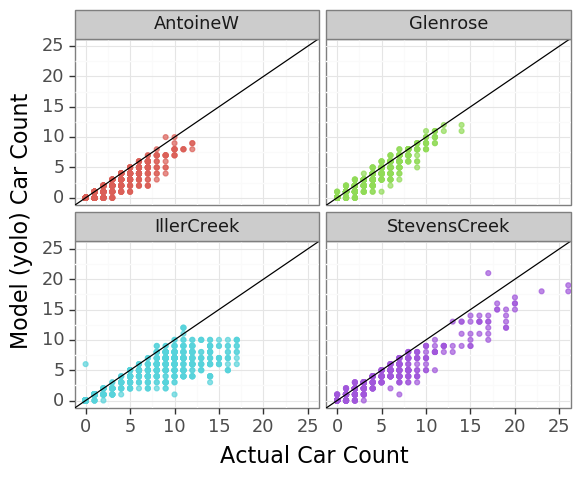

<ggplot: (8790419533445)>

In [94]:
ggplot(all_validated, aes(x = "car_count", y = "yolo_car_count", color = "Parking_lot")) +\
    geom_point(alpha = .7) +\
    geom_abline( slope = 1, intercept = 0) +\
    coord_cartesian(xlim = (0,25), ylim = (0,25)) +\
    labs(x = "Actual Car Count", y = "Model (yolo) Car Count") +\
    theme_bw(base_size= 16) +\
    scale_color_discrete(guide=False)+\
    facet_wrap("Parking_lot")

In [147]:
melt_counts = all_validated.melt(id_vars= ('Parking_lot', 'date_time'), value_vars=('yolo_car_count', 'car_count'), 
                   var_name='count_source', value_name='car_count')

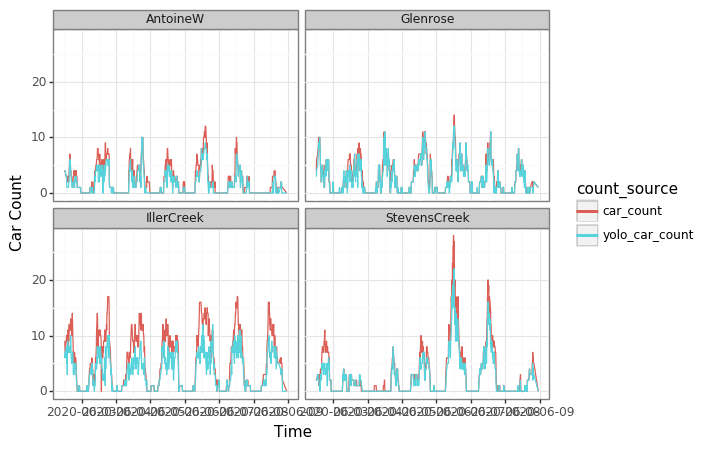

<ggplot: (8776071539501)>

In [148]:
ggplot(melt_counts, aes(x = "date_time", y = "car_count", color = "count_source")) +\
  geom_line() +\
  labs(x = "Time", y = "Car Count") +\
  theme_bw() +\
  facet_wrap("Parking_lot")

In [3]:
indexed = all_validated.set_index( "date_time")

In [5]:
#indexed = indexed.drop(["file_name", "image"], 1)
indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3406 entries, 2020-06-02 12:03:00 to 2020-06-08 01:54:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Parking_lot     3406 non-null   object 
 1   yolo_car_count  3406 non-null   int64  
 2   car_count       3406 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 106.4+ KB


In [6]:
#df.groupby(['State','City']).resample('2D').sum()
hourly = indexed.groupby(['Parking_lot']).resample('H').mean()

In [7]:
hourly.head()

yolo_car_count  car_count
Parking_lot date_time                                     
AntoineW    2020-06-02 12:00:00        4.000000   4.000000
            2020-06-02 13:00:00        2.000000   2.500000
            2020-06-02 14:00:00        1.000000   2.666667
            2020-06-02 15:00:00        3.833333   4.666667
            2020-06-02 16:00:00        4.000000   4.166667

In [8]:
hourly = hourly.reset_index()

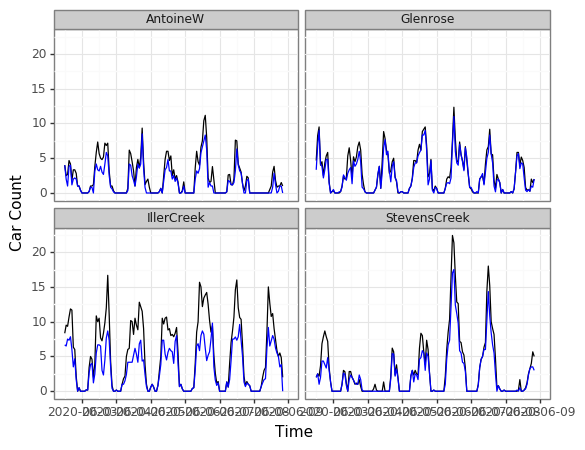

<ggplot: (8790413783177)>

In [9]:
ggplot(hourly, aes(x = "date_time", y = "car_count")) +\
    geom_line() +\
    geom_line(aes(y = "yolo_car_count"), color = "blue") +\
    labs(x = "Time", y = "Car Count") +\
    theme_bw() +\
    facet_wrap("Parking_lot")

In [10]:
# make week_day vs week_end category
hourly['day_of_week'] = hourly['date_time'].dt.day_name()
hourly.head()

,Parking_lot,date_time,yolo_car_count,car_count,day_of_week
0,AntoineW,2020-06-02 12:00:00,4.000000,4.000000,Tuesday
1,AntoineW,2020-06-02 13:00:00,2.000000,2.500000,Tuesday
2,AntoineW,2020-06-02 14:00:00,1.000000,2.666667,Tuesday
3,AntoineW,2020-06-02 15:00:00,3.833333,4.666667,Tuesday
4,AntoineW,2020-06-02 16:00:00,4.000000,4.166667,Tuesday


In [11]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
weekends = ["Saturday", "Sunday"]

In [12]:
hourly["is_weekend"] = hourly.day_of_week.apply(lambda x: True if x in weekends else False)

In [13]:
hourly = hourly.set_index("date_time")
hourly.head()
# indexed.groupby(['Parking_lot']).resample('H').mean()
# df.groupby([df["Date/Time"].dt.year, df["Date/Time"].dt.hour]).mean()

,Parking_lot,yolo_car_count,car_count,day_of_week,is_weekend
date_time,,,,,
2020-06-02 12:00:00,AntoineW,4.000000,4.000000,Tuesday,False
2020-06-02 13:00:00,AntoineW,2.000000,2.500000,Tuesday,False
2020-06-02 14:00:00,AntoineW,1.000000,2.666667,Tuesday,False
2020-06-02 15:00:00,AntoineW,3.833333,4.666667,Tuesday,False
2020-06-02 16:00:00,AntoineW,4.000000,4.166667,Tuesday,False


In [14]:
weekday_vs_weekend = hourly.groupby(['Parking_lot', 'is_weekend', hourly.index.hour]).mean()

In [15]:
weekday_vs_weekend = weekday_vs_weekend.reset_index()


In [24]:
#df['DataFrame Column'] = df['DataFrame Column'].replace(np.nan, 0)
weekday_vs_weekend["yolo_car_count"]  = weekday_vs_weekend["yolo_car_count"].replace(0, np.nan)

In [25]:
weekday_vs_weekend["yolo_pct"] = weekday_vs_weekend.groupby(["Parking_lot"]).yolo_car_count.rank(pct=True)

#weekday_vs_weekend["actual_pct"] = weekday_vs_weekend["car_count"].rank(pct=True)

In [26]:
weekday_vs_weekend["yolo_pct"] = weekday_vs_weekend["yolo_pct"].replace(np.nan, 0)

In [27]:
weekday_vs_weekend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Parking_lot     192 non-null    object 
 1   is_weekend      192 non-null    bool   
 2   date_time       192 non-null    int64  
 3   yolo_car_count  153 non-null    float64
 4   car_count       192 non-null    float64
 5   yolo_pct        192 non-null    float64
 6   actual_pct      192 non-null    float64
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 9.3+ KB


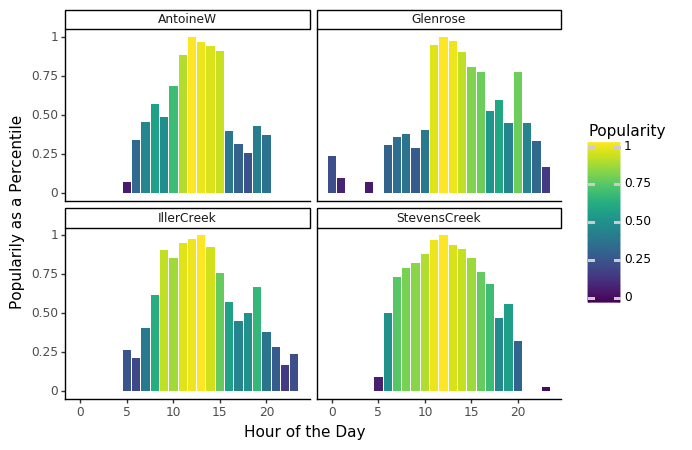

<ggplot: (8790419351009)>

In [28]:
ggplot(weekday_vs_weekend[weekday_vs_weekend["is_weekend"] == True], aes(x = "date_time", y = "yolo_pct")) +\
    geom_bar(aes(fill = "yolo_pct"), stat = "identity") +\
    facet_wrap("Parking_lot") +\
    theme_classic() +\
    labs(x = "Hour of the Day", y = "Popularily as a Percentile", fill = "Popularity")

In [29]:
wd_Glen = weekday_vs_weekend[(weekday_vs_weekend["is_weekend"] ==  False) & (weekday_vs_weekend["Parking_lot"] == "Glenrose")]
wd_Glen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 48 to 71
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Parking_lot     24 non-null     object 
 1   is_weekend      24 non-null     bool   
 2   date_time       24 non-null     int64  
 3   yolo_car_count  21 non-null     float64
 4   car_count       24 non-null     float64
 5   yolo_pct        24 non-null     float64
 6   actual_pct      24 non-null     float64
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 1.3+ KB


In [51]:
hour = datetime.datetime.now()

In [53]:
int(hour.strftime('%H'))

18

In [75]:
def plot_popular_times(df, hour):
    labels = list(df.date_time)
    x = np.arange(len(df.date_time))  # the label locations
    y = df.yolo_pct
    width = 0.8

    fig, ax = plt.subplots()
    mask1 = y < 0.5
    mask2 = (y >= 0.5) & (y < .75)
    mask3 = y >= .75
    now_mask = x == hour

    plt.bar(x[now_mask], y[now_mask] + .01, width = 1.1)
    plt.bar(x[mask1], y[mask1], color = "#508104", width = width)
    plt.bar(x[mask2], y[mask2], color = "#f3b800", width = width)
    plt.bar(x[mask3], y[mask3], color = '#b64201', width = width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    #ax.set_ylabel('')
    ax.set_title('Popular Times Today')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.ylim(top = 1)

    fig.tight_layout()

    plt.show()


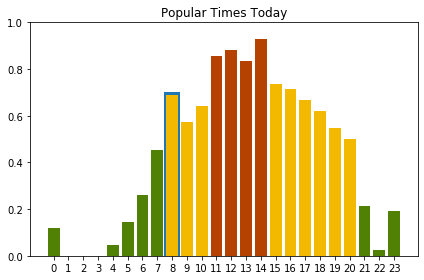

In [79]:
plot_popular_times(wd_Glen, 8)

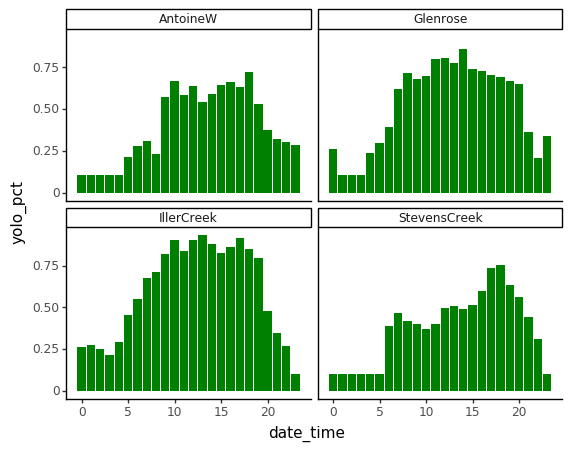

<ggplot: (8776077778937)>

In [175]:
ggplot(weekday_vs_weekend[weekday_vs_weekend["is_weekend"] == False], aes(x = "date_time", y = "yolo_pct")) +\
    geom_bar(stat = "identity", fill = "green") +\
    facet_wrap("Parking_lot") +\
    theme_classic() +\
    labs()

In [212]:
import datetime
datetime.datetime.today().weekday()

3

In [216]:
wd_Glen.iloc[max(wd_Glen.date_time)]

Parking_lot        Glenrose
is_weekend            False
date_time                23
yolo_car_count     0.433333
car_count          0.473333
yolo_percentile    0.338542
yolo_pct           0.338542
actual_pct           0.3125
Name: 71, dtype: object

In [63]:
just_glen = all_validated[all_validated.Parking_lot == "Glenrose"]
just_glen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 162 to 3405
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Parking_lot     853 non-null    object        
 1   yolo_car_count  853 non-null    int64         
 2   car_count       853 non-null    float64       
 3   date_time       853 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 33.3+ KB


In [64]:
max(just_glen.date_time)

Timestamp('2020-06-08 23:05:00')

In [65]:
current = just_glen[just_glen["date_time"] == max(just_glen.date_time)]
current

,Parking_lot,yolo_car_count,car_count,date_time
3343,Glenrose,1,1.0,2020-06-08 23:05:00


In [87]:
def plot_current(df):
    labels = ["now"]
    x = np.arange(len(df.date_time))  # the label locations
    y = df.yolo_pct

    mask1 = y < 0.5
    mask2 = (y >= 0.5) & (y < .75)
    mask3 = y >= .75

    fig, ax = plt.subplots(figsize=(10, 1))
    if mask1:
        plt.barh(labels, y, color = "#508104")
    if mask2:
        plt.barh(labels, y, color = "#f3b800")
    if mask3:
        plt.barh(labels, y, color = '#b64201')

    ax.set_title('Current Popularity')
    plt.xlim(0,1)

    fig.tight_layout()

    plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

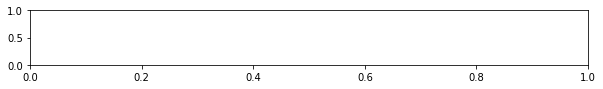

In [88]:
plot_current(current)

In [ ]:
height = [3, 12, 5, 18, 45]
bars = ('A', 'B', 'C', 'D', 'E')
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.show()


In [210]:
weekday, weekend = (0,1,2,3,4) , (6,5)

In [211]:
today_is_we = datetime.datetime.today().weekday() in weekend
today_is_we

False